In [1]:
import warnings
warnings.filterwarnings('ignore')

1. mnist 이미지 분류

In [2]:
import zipfile
with zipfile.ZipFile('../data/mnist/dataset.zip') as zip_ref:
    zip_ref.extractall('../data/mnist/')

In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',version=1,data_home='../data/mnist', as_frame=False)

In [4]:
import numpy as np
X, y = mnist["data"], mnist["target"]
y = y.astype(np.int64)
print(X.shape, y.shape)

(70000, 784) (70000,)


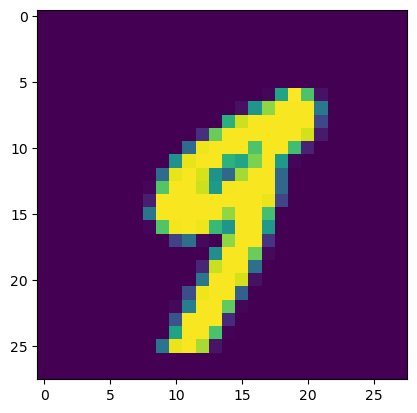

In [5]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image)
plt.show()

In [6]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=matplotlib.cm.binary)
    plt.axis('off')

9

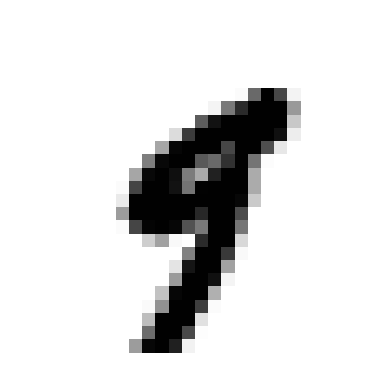

In [7]:
plot_digit(X[36000])
y[36000]

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [9]:
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

- 이진 분류기

In [10]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [11]:
# 확률적 경사하강법 분류모형(온라인학습)
# 확률적 경사하강법(Stochastic Gradient Descent, SGD)
# 무작위로 1개의 데이터를 추출하여 기울기를 계산
# 빠르게 최적점을 찾을 수 있는 알고리즘
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=5, random_state=0)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(max_iter=5, random_state=0)

In [12]:
sgd_clf.predict([some_digit])

array([False])

In [13]:
# 교차검증
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9539 , 0.93255, 0.95895])

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# 클래스 비율이 유지되는 교차검증
skfolds = StratifiedKFold(n_splits=3)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    # 분류모형을 복제(데이터는 복제하지 않음)
    clone_clf = clone(sgd_clf)
    # 학습용,검증용 구분
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    # 학습
    clone_clf.fit(X_train_folds, y_train_folds)
    # 분류
    y_pred = clone_clf.predict(X_test_folds)
    # 정확도
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))

0.9539
0.93255
0.95895


In [15]:
# 모든 예측결과를 False로 리턴하는 테스트용 클래스
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        # 2원 영배열(행의수는 샘플개수), 0을 False로 리턴
        return np.zeros((len(X), 1), dtype=bool)

In [16]:
never_5_clf = Never5Classifier()
print(never_5_clf.predict(X_train))
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')
# 정확도가 높음(이미지의 10%가 5이므로 5가 아니라고 분류하면 100-10=90% 정도의 정확도를 가짐)
# 이 모형은 좋은 모형이 아님, 특히 불균형 데이터셋의 경우 정확도는 큰 의미가 없을 수 있음

[[False]
 [False]
 [False]
 ...
 [False]
 [False]
 [False]]


array([0.9119 , 0.9076 , 0.90945])

In [17]:
from sklearn.metrics import classification_report
print(classification_report(never_5_clf.predict(X_train), y_train_5))

              precision    recall  f1-score   support

       False       1.00      0.91      0.95     60000
        True       0.00      0.00      0.00         0

    accuracy                           0.91     60000
   macro avg       0.50      0.45      0.48     60000
weighted avg       1.00      0.91      0.95     60000



In [18]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_train_pred = sgd_clf.predict(X_train)

# 오차행렬
cm = confusion_matrix(y_train_5, y_train_pred)
print(cm)
tn, fp, fn, tp = cm.ravel()
print(tn, fp, fn, tp)

[[53861   718]
 [ 1131  4290]]
53861 718 1131 4290


In [19]:
from sklearn.metrics import precision_score, recall_score
# 정밀도 :TP / (TP + FP), 모형이 1로 분류한 것 중 실제로 1인 것의 비율
print(precision_score(y_train_5, y_train_pred))
print(tp/(tp+fp))

0.856629392971246
0.856629392971246


In [20]:
# 민감도(TPR, True Positive Rate) - 1을 1로 잘 맞춘 비율, 재현율(recall)이라고도 함
print(recall_score(y_train_5, y_train_pred))
print(tp/(tp+fn)) 

0.7913669064748201
0.7913669064748201


In [21]:
from sklearn.metrics import f1_score
# 정밀도와 재현율의 조화 평균
f1_score(y_train_5, y_train_pred)
# 정밀도와 재현율은 반비례하는 관계 : 정밀도를 높이면 재현율이 떨어지고 재현율이 높아지면 정밀도가 낮아짐
# 정밀도/재현율 트레이드오프라고 함

0.8227059161952248

In [22]:
# sgd 모형의 판별 함수
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([-277479.10182054])

In [23]:
# 판별함수의 값 0을 기준으로 분류하는 함수
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred # False로 분류됨

array([False])

In [24]:
# 판별함수의 결과값을 조절함
threshold = -417921
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [25]:
# 예측결과가 아닌 결정점수를 리턴하는 교차검증
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
print(y_scores)
print(y_scores.shape)

[-663333.52191762 -748921.2611601    13572.48258986 ... -837117.47689862
 -636244.38797779  318897.22964217]
(60000,)


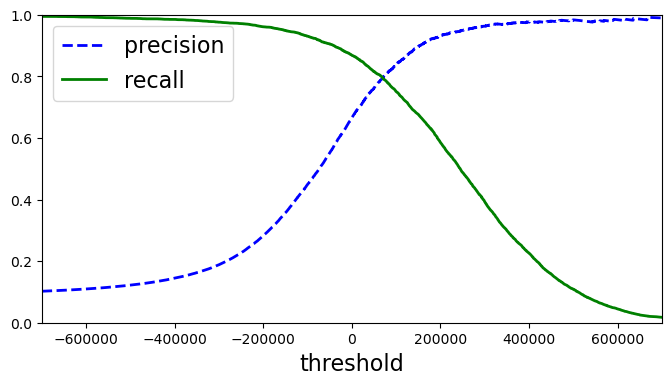

In [26]:
from sklearn.metrics import precision_recall_curve
# 판별함수의 결과값을 이용하여 모든 임계값에 대한 정밀도와 재현율 계산
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="recall",linewidth=2)
    plt.xlabel("threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
plt.show()
# 판별기준을 높이면 정밀도는 높아지고 재현율은 낮아짐
# 판별기준을 낮추면 정밀도는 낮아지고 재현율은 높아짐


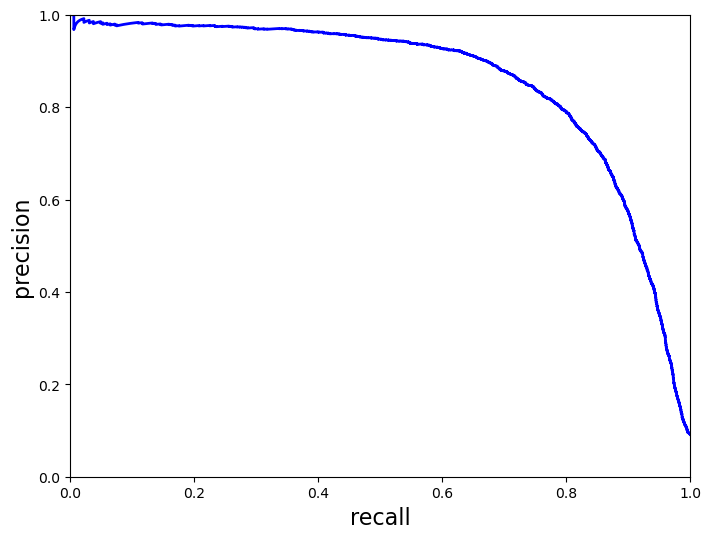

In [27]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("recall", fontsize=16)
    plt.ylabel("precision", fontsize=16)
    plt.axis([0, 1, 0, 1])


plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()
# precision과 recall은 반비례 관계

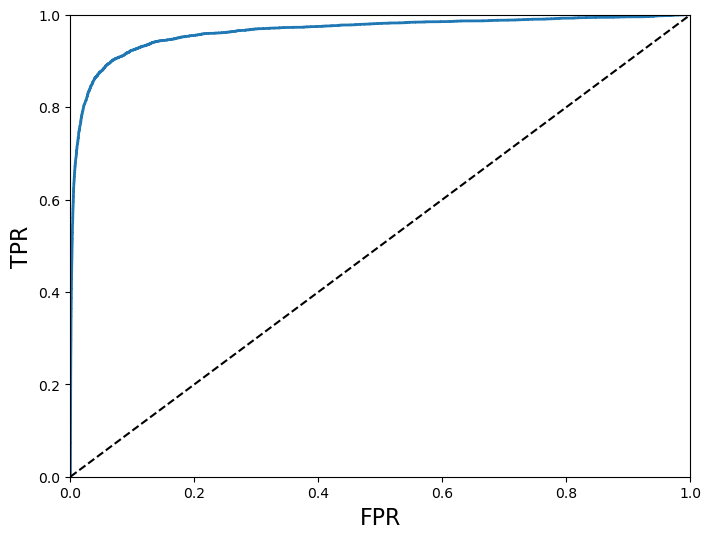

In [28]:
# ROC Curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('FPR', fontsize=16)
    plt.ylabel('TPR', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr,tpr)
plt.show()

In [29]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)
# 면적이 1에 가까울수록 완벽한 모형, 0.5이면 완전한 랜덤 분류기

0.964335094465388

In [30]:
# sgd 모형과 비교하기 위하여 랜덤포레스트모형 추가
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)

# predict_proba : 랜덤포레스트에서 decision_function() 대신 제공되는 함수
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,method="predict_proba")

In [31]:
y_probas_forest # 0일 확률, 1일 확률

array([[1. , 0. ],
       [1. , 0. ],
       [0.9, 0.1],
       ...,
       [1. , 0. ],
       [1. , 0. ],
       [0.1, 0.9]])

In [32]:
y_scores_forest = y_probas_forest[:, 1] # 1일 확률
print(y_scores_forest)
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

[0.  0.  0.1 ... 0.  0.  0.9]


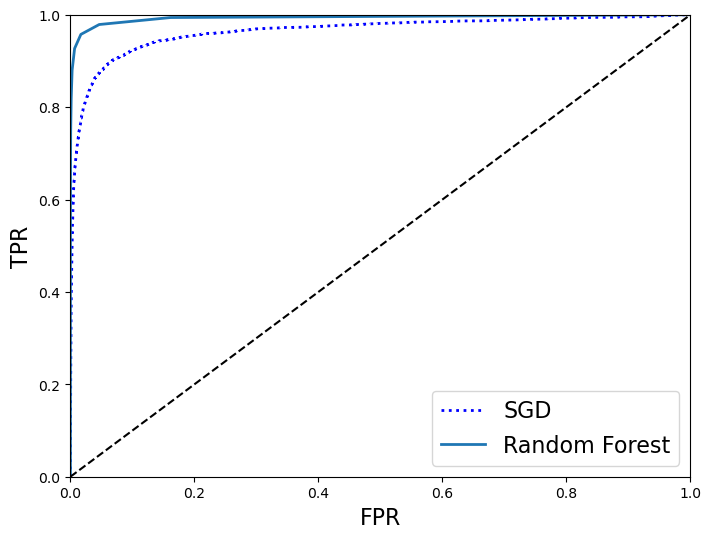

In [33]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [34]:
# sgd보다 랜덤포레스트 모형의 성능이 더 좋음
roc_auc_score(y_train_5, y_scores_forest)

0.9933877758580674

In [35]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9844686043931662

In [36]:
recall_score(y_train_5, y_train_pred_forest)

0.8184836745987825

- 다중 분류

In [37]:
# 다중분류를 위해 모든 데이터를 학습에 사용
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])
# 내부적으로 10개의 이진분류기를 훈련시키고 각각의 결정점수를 비교하여 가장 점수가 높은 클래스를 선택함

array([4], dtype=int64)

In [38]:
# 판별함수 확인, 클래스별로 10개의 점수가 출력됨
some_digit_scores = sgd_clf.decision_function([some_digit])
print(some_digit_scores)

# 가장 높은 점수 출력
print(np.argmax(some_digit_scores))

# 라벨(클래스) 리스트
print(sgd_clf.classes_)

# 분류한 라벨 이름
print(sgd_clf.classes_[5])

[[-685803.43698082 -427265.86807441 -731433.87488964 -260035.64007264
   -12030.40340804 -331924.89500152 -513296.71067206 -276269.55516377
  -303819.55815081 -315599.41858875]]
4
[0 1 2 3 4 5 6 7 8 9]
5


- 일대다전략과 일대일전략
- 일대다전략(one versus all, one versus the rest): 각 분류기의 결정점수 중에서 가장 높은 것을 선택하는 전략(0만 찾는 모형, 1만 찾는 모형, 대부분의 알고리즘에서 사용하는 방식)
- 일대일전략(one versus one): 0과 1, 0과 2 등으로 각 숫자의 조합마다 여러개의 모형을 만들어서 가장 성능이 좋은 모형을 채택하는 방식(svm에서 사용하는 방식)
- 사이킷런에서는 svm일 경우 OvO(일대일전략)을 다른 분류모형일 경우 OvA(일대다전략)을 선택함, 랜덤포레스트모형은 앙상블 모형이 므로 사이킷런의 OvA, OvO를 적용하지 않음

In [39]:
from sklearn.multiclass import OneVsOneClassifier
# 일대일전략을 사용하도록 지정하는 방법
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, random_state=0))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([9], dtype=int64)

In [40]:
len(ovo_clf.estimators_) # 일대일전략에서 사용하는 분류기의 개수
pred = ovo_clf.predict(X_test)
np.mean(pred == y_test)

0.9149

In [41]:
from sklearn.multiclass import OneVsRestClassifier
# 1대다 전략(0과 1~9)
ovr_clf = OneVsRestClassifier(SGDClassifier(max_iter=5, random_state=10))
ovr_clf.fit(X_train, y_train)
len(ovr_clf.estimators_) # 분류기 개수
pred = ovr_clf.predict(X_test)
np.mean(pred == y_test)

0.8852

- 다중 레이블 분류

In [42]:
# 학습시간이 오래 걸림
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7) # 7,8,9
y_train_odd = (y_train % 2 == 1) # 홀수
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [43]:
knn_clf.predict([some_digit])
# 7,8,9에 해당되고 홀수이다

array([[ True,  True]])

2. mnist 분류(교차검증)

- K-fold 교차 검증

In [44]:
# 1. K-fold 교차 검증
from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# 숫자 데이터셋을 로드
digits = datasets.load_digits()

# 특성 행렬
features = digits.data
target = digits.target

# 표준화 객체
standardizer = StandardScaler()

# 로지스틱 회귀 객체
logit = LogisticRegression()

# 표준화한 다음 로지스틱 회귀를 실행하는 파이프라인
pipeline = make_pipeline(standardizer, logit)

# k-폴드 교차검증
kf = KFold(n_splits=10, shuffle=True, random_state=1)

# k-폴드 교차검증을 수행
cv_results = cross_val_score(pipeline, # 파이프라인
                             features, # 특성 행렬
                             target, # 타깃 벡터
                             cv=kf, # 교차 검증 기법
                             scoring="accuracy", # 평가 지표
                             n_jobs=-1) # 모든 CPU 코어 사용

# 평균을 계산
cv_results.mean()

0.9693916821849783

- ShuffleSplit

In [45]:
# 2. ShuffleSplit : 반복횟수에 관계없이 학습용, 검증용 데이터셋을 임의로 지정할 수 있음
# 반복마다 랜덤하게 분할하므로 하나의 샘플이 여러번 포함될 수 있음

from sklearn.model_selection import ShuffleSplit

# ShuffleSplit 분할기(학습용 50%, 검증용 20%)
ss = ShuffleSplit(n_splits=10, train_size=0.5, test_size=0.2, random_state=42)
pipeline = make_pipeline(standardizer, logit)

# 교차검증을 수행
cv_results = cross_val_score(pipeline, 
                             features, 
                             target, 
                             cv=ss, 
                             scoring="accuracy",
                             n_jobs=-1)

# 평균을 계산
cv_results.mean()

0.9630555555555554

- RepeatedKFold

In [46]:
# 3. RepeatedKFold 교차검증
from sklearn.model_selection import RepeatedKFold

# RepeatedKFold 분할기(10회 교차검증을 5회 반복)
rk = RepeatedKFold(n_splits=10, n_repeats=5, random_state=42)

# 교차검증을 수행
cv_results = cross_val_score(pipeline, 
                             features, 
                             target, 
                             cv=rk, 
                             scoring="accuracy", 
                             n_jobs=-1)

# 검증 점수 개수를 확인
print(len(cv_results))

# 평균을 계산
print(cv_results.mean())

50
0.9695065176908755


- 하이퍼파라미터 값의 영향을 시각화하기

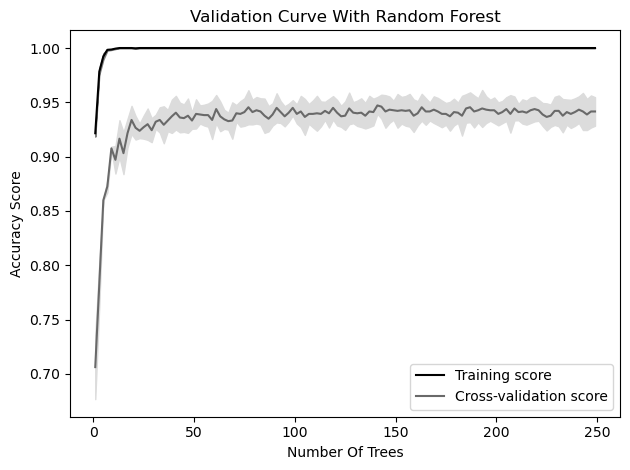

In [47]:
# 4. 하이퍼파라미터 값의 영향을 시각화하기
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import validation_curve

# 데이터를 로드
digits = load_digits()

# 특성 행렬과 타깃 벡터
features, target = digits.data, digits.target

# 파라미터 값의 범위
param_range = np.arange(1, 250, 2)

# 파라미터 값의 범위를 사용하여 학습용 데이터셋과 검증용 데이터셋의 정확도를 계산
train_scores, test_scores = validation_curve(RandomForestClassifier(),
                                             features,
                                             target,
                                             param_name="n_estimators",
                                             param_range=param_range,
                                             cv=3,
                                             scoring="accuracy",
                                             n_jobs=-1)

# 학습용 데이터셋 점수의 평균과 표준 편차를 계산
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# 검증용 데이터셋 점수의 평균과 표준 편차를 계산
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# 학습용 데이터셋과 검증용 데이터셋의 평균 정확도 점수
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

# 학습용 데이터셋과 검증용 데이터셋의 정확도에 대한 표준 편차 그래프
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

# 그래프를 출력
plt.title("Validation Curve With Random Forest")
plt.xlabel("Number Of Trees")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc = "best")
plt.show()

2. 이미지 데이터 증식

In [48]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',version=1,data_home='../data/mnist', as_frame=False)

In [49]:
import numpy as np
X, y = mnist["data"], mnist["target"]
y = y.astype(np.int64)
print(X.shape, y.shape)

(70000, 784) (70000,)


In [50]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [51]:
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [52]:
from scipy.ndimage import shift
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx])
    return shifted_image.reshape([-1])

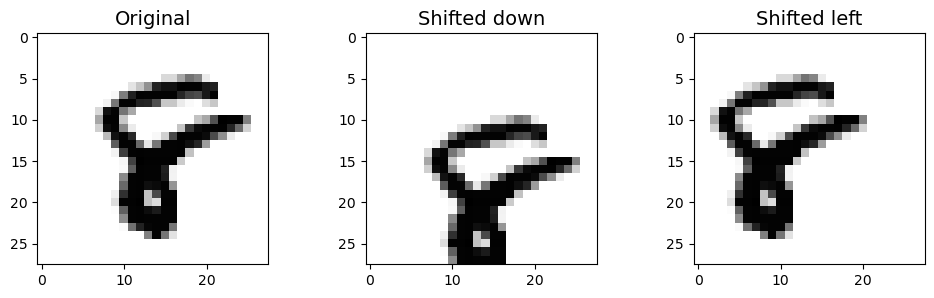

In [53]:
import matplotlib.pyplot as plt
image = X_train[70]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)
plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), cmap="Greys")
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), cmap="Greys")
plt.show()

In [54]:
# 오래 걸림
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

# 원본 이미지 6만개 + 쉬프트시긴 이미지 24만개 => 30만개로 증식됨
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)
X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [55]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [56]:
# 오래 걸림
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors=1)
knn_clf.fit(X_train_augmented[:1000], y_train_augmented[:1000])

KNeighborsClassifier(n_neighbors=1)

In [57]:
from sklearn.metrics import accuracy_score
y_pred = knn_clf.predict(X_test[:1000])
accuracy_score(y_test[:1000], y_pred[:1000])

0.831

4. mnist(로지스틱 회귀분석)

In [58]:
from keras.datasets import mnist

# 학습용과 검증용 분리
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 데이터 전처리
# 28x28 => 784로 변환
X_train = X_train.reshape(60000, 784).astype('float32') / 255.0
X_test = X_test.reshape(10000, 784).astype('float32') / 255.0
# 사이킷런은 2차원만 처리 가능하므로 2차원으로 reshape (차원축소), 그리고 255로 나누어 값의 크기를 축소 (정규화)
print(y_train[:5])

[5 0 4 1 9]


In [59]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
print("학습용:",model.score(X_train, y_train))
print("검증용:",model.score(X_test, y_test))

학습용: 0.9392833333333334
검증용: 0.9256


In [60]:
# 모형 저장
import pickle # 케라스는 따로 저장 라이브러리가 있지만, 사이킷런은 없다.
pickle.dump(model, open('../models/mnist/mnist_logit.model', 'wb'))

In [61]:
# 모형 불러오기
model = pickle.load(open('../models/mnist/mnist_logit.model', 'rb'))

# 모형 사용
pred = model.predict(X_test[:10])
print('예측값:',pred[:10])
print('실제값:',y_test[:10])

예측값: [7 2 1 0 4 1 4 9 6 9]
실제값: [7 2 1 0 4 1 4 9 5 9]


In [62]:
# confusion matrix(혼동행렬, 오분류표) 출력
from sklearn.metrics import confusion_matrix
import pandas as pd
pred = model.predict(X_test)
cm = confusion_matrix(y_test, pred)
df_cm = pd.DataFrame(cm, index=range(10), columns=range(10))
df_cm

,0,1,2,3,4,5,6,7,8,9
0,955,0,2,4,1,10,4,3,1,0
1,0,1110,5,2,0,2,3,2,11,0
2,6,9,930,14,10,3,12,10,34,4
3,4,1,16,925,1,23,2,10,19,9
4,1,3,7,3,921,0,6,5,6,30
5,9,2,3,35,10,777,15,6,31,4
6,8,3,8,2,6,16,912,2,1,0
7,1,7,23,7,6,1,0,947,4,32
8,9,11,6,22,7,29,13,10,855,12
9,9,8,1,9,21,7,0,21,9,924


5. mnist(의사결정나무)

In [63]:
from keras.datasets import mnist
# 학습용과 검증용 분리
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 데이터 전처리
X_train = X_train.reshape(60000, 784).astype('float32') / 255.0
X_test = X_test.reshape(10000, 784).astype('float32') / 255.0
print(y_train[:5])

[5 0 4 1 9]


In [64]:
from sklearn.tree import DecisionTreeClassifier

# 트리 모델 생성(이미지 100장만 학습)
model = DecisionTreeClassifier(random_state=0)
model.fit(X_train[:100], y_train[:100])
print("학습용:", model.score(X_train, y_train))
print("검증용", model.score(X_test, y_test))

학습용: 0.3793666666666667
검증용 0.3731


In [65]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.90      0.91      1032
           3       0.90      0.92      0.91      1010
           4       0.94      0.94      0.94       982
           5       0.90      0.87      0.88       892
           6       0.94      0.95      0.95       958
           7       0.93      0.92      0.93      1028
           8       0.88      0.88      0.88       974
           9       0.91      0.92      0.91      1009

    accuracy                           0.93     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.93      0.93      0.93     10000



In [66]:
# 모형 저장
import pickle
pickle.dump(model, open('../models/mnist/mnist_tree.model', 'wb'))

In [67]:
# 모형 불러오기
model = pickle.load(open('../models/mnist/mnist_tree.model', 'rb'))

# 모형 사용
pred = model.predict(X_test[:10])
print('예측값:',pred[:10])
print('실제값:',y_test[:10])

예측값: [7 0 1 0 4 1 9 9 4 9]
실제값: [7 2 1 0 4 1 4 9 5 9]


In [68]:
# confusion matrix(혼동행렬, 오분류표) 출력
from sklearn.metrics import confusion_matrix
import pandas as pd

pred = model.predict(X_test)
cm = confusion_matrix(y_test, pred)
df_cm = pd.DataFrame(cm, index=range(10), columns = range(10))
df_cm

,0,1,2,3,4,5,6,7,8,9
0,525,6,44,0,163,70,28,50,20,74
1,0,770,5,70,142,19,12,29,49,39
2,37,99,119,21,295,126,149,72,39,75
3,38,20,22,437,58,69,31,138,84,113
4,181,2,38,6,337,19,10,101,146,142
5,71,4,21,155,70,152,31,159,78,151
6,11,1,62,7,295,41,328,42,91,80
7,19,49,52,9,90,77,0,629,16,87
8,48,43,84,61,231,122,19,33,225,108
9,98,10,19,52,200,37,5,190,189,209


6. mnist(랜덤포레스트)

In [69]:
from keras.datasets import mnist

# 학습용과 검증용 분리
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 데이터 전처리
X_train = X_train.reshape(60000, 784).astype('float32') / 255.0
X_test = X_test.reshape(10000, 784).astype('float32') / 255.0
print(y_train[:5])

[5 0 4 1 9]


In [70]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=100, random_state=10)
forest.fit(X_train[:100], y_train[:100])
print("학습용:",forest.score(X_train, y_train))
print("검증용:",forest.score(X_test, y_test))

학습용: 0.6511666666666667
검증용: 0.6469


In [71]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.51      0.54      0.52       980
           1       0.77      0.68      0.72      1135
           2       0.26      0.12      0.16      1032
           3       0.53      0.43      0.48      1010
           4       0.18      0.34      0.24       982
           5       0.21      0.17      0.19       892
           6       0.54      0.34      0.42       958
           7       0.44      0.61      0.51      1028
           8       0.24      0.23      0.24       974
           9       0.19      0.21      0.20      1009

    accuracy                           0.37     10000
   macro avg       0.39      0.37      0.37     10000
weighted avg       0.39      0.37      0.37     10000



In [72]:
# 모형 저장
pickle.dump(model, open('../models/mnist/mnist_rf.model', 'wb'))

In [73]:
# 모형 불러오기
model = pickle.load(open('../models/mnist/mnist_rf.model', 'rb'))
# 모형 사용
pred = model.predict(X_test[:10])
print('예측값:',pred[:10])
print('실제값:',y_test[:10])

예측값: [7 0 1 0 4 1 9 9 4 9]
실제값: [7 2 1 0 4 1 4 9 5 9]


In [74]:
pred = model.predict(X_test)
cm = confusion_matrix(y_test, pred)
df_cm = pd.DataFrame(cm, index=range(10), columns=range(10))
df_cm

,0,1,2,3,4,5,6,7,8,9
0,525,6,44,0,163,70,28,50,20,74
1,0,770,5,70,142,19,12,29,49,39
2,37,99,119,21,295,126,149,72,39,75
3,38,20,22,437,58,69,31,138,84,113
4,181,2,38,6,337,19,10,101,146,142
5,71,4,21,155,70,152,31,159,78,151
6,11,1,62,7,295,41,328,42,91,80
7,19,49,52,9,90,77,0,629,16,87
8,48,43,84,61,231,122,19,33,225,108
9,98,10,19,52,200,37,5,190,189,209


7. mnist(사례기반추론)

In [75]:
from keras.datasets import mnist

# 학습용과 검증용 분리
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 데이터 전처리
X_train = X_train.reshape(60000, 784).astype('float32') / 255.0
X_test = X_test.reshape(10000, 784).astype('float32') / 255.0
print(y_train[:5])

[5 0 4 1 9]


[0.67, 0.66, 0.66, 0.67, 0.65, 0.67, 0.68, 0.67, 0.67, 0.66]
최적의 k: 7
최고 정확도: 0.68


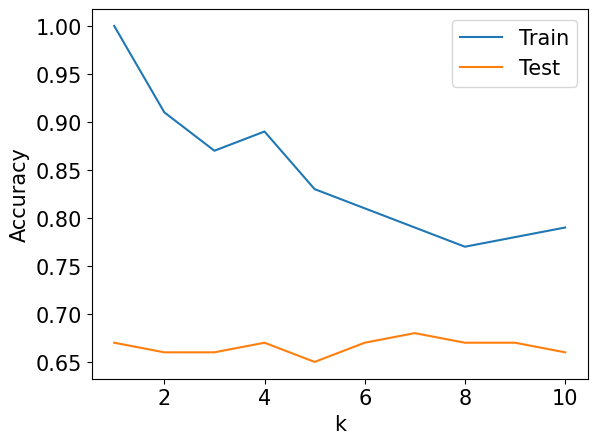

In [76]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

train_rate = []
test_rate = []
# 새로운 데이터 포인트에 가장 가까운 k개의 이웃을 찾는다.
# k의 값에 따라 결과가 달라지므로 어떤 값이 최적인지 찾아내는 것이 필요함
# 1 에서 10 까지 n_neighbors 를 적용
neighbors = range(1, 11)
for n in neighbors:
    # 모델 생성
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train[:100], y_train[:100])
    # 학습용 데이터셋의 정확도
    train_rate.append(knn.score(X_train[:100], y_train[:100]))
    # 검증용 데이터셋의 정확도
    test_rate.append(knn.score(X_test[:100], y_test[:100]))

plt.rcParams["font.size"]=15
plt.plot(neighbors, train_rate, label="Train")
plt.plot(neighbors, test_rate, label="Test")
plt.ylabel("Accuracy")
plt.xlabel("k")
plt.legend()

print(test_rate)
max_rate=max(test_rate)
idx=np.argmax(test_rate)
print('최적의 k:',idx+1)
print('최고 정확도:',max_rate)

In [77]:
model = KNeighborsClassifier(n_neighbors=7)
model.fit(X_train[:100], y_train[:100])
print("학습용:",model.score(X_train[:100], y_train[:100]))
print("검증용:",model.score(X_test[:100], y_test[:100]))

학습용: 0.79
검증용: 0.68


In [78]:
# 모형 저장
import pickle
pickle.dump(model, open('../models/mnist/mnist_knn.model', 'wb'))

In [79]:
# 모형 불러오기
model = pickle.load(open('../models/mnist/mnist_knn.model', 'rb'))
# 모형 사용
pred = model.predict(X_test[:10])
print('예측값:',pred[:10])
print('실제값:',y_test[:10])

예측값: [7 6 1 0 4 1 9 4 1 9]
실제값: [7 2 1 0 4 1 4 9 5 9]


In [80]:
# confusion matrix(혼동행렬, 오분류표) 출력
from sklearn.metrics import confusion_matrix
import pandas as pd

pred = model.predict(X_test)
cm = confusion_matrix(y_test, pred)
df_cm = pd.DataFrame(cm, index=range(10),
columns = range(10))
df_cm

,0,1,2,3,4,5,6,7,8,9
0,866,11,2,11,8,10,54,15,1,2
1,0,1134,0,1,0,0,0,0,0,0
2,45,488,260,19,75,4,55,14,58,14
3,40,122,2,772,2,3,8,8,38,15
4,1,83,0,4,519,0,29,26,1,319
5,72,98,3,352,65,92,54,36,42,78
6,17,103,4,4,44,5,779,1,0,1
7,1,137,1,13,29,0,1,637,12,197
8,59,172,20,146,36,3,35,14,441,48
9,17,42,3,56,230,0,10,90,5,556


8. mnist(SVM)

In [81]:
from keras.datasets import mnist

# 학습용과 검증용 분리
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 데이터 전처리
X_train = X_train.reshape(60000, 784).astype('float32') / 255.0
X_test = X_test.reshape(10000, 784).astype('float32') / 255.0
print(y_train[:5])

[5 0 4 1 9]


In [82]:
# 시간이 오래 걸리므로 이미지 100장만 학습
from sklearn.svm import SVC

model = SVC()
model.fit(X_train[:100], y_train[:100])
print("학습용:",model.score(X_train, y_train))
print("검증용:",model.score(X_test, y_test))

학습용: 0.6564666666666666
검증용: 0.6559


In [83]:
# 최적의 C value와 gamma value를 찾는 과정
import matplotlib.pyplot as plt
import numpy as np

train_rate = []
test_rate = []
c_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
g_values = [0.0001, 0.001, 0.01, 0.1]
for n in c_values:
    for g in g_values:
        # 모델 생성
        model = SVC(C=n,gamma=g,random_state=10)
        model.fit(X_train[:100], y_train[:100])
        # 학습용 데이터셋의 정확도
        train_rate.append([n,g,model.score(X_train[:100], y_train[:100])])
        # 검증용 데이터셋의 정확도
        test_rate.append([n,g,model.score(X_test[:100], y_test[:100])])

train_arr=np.array(train_rate) #검증용 데이터셋의 정확도
test_arr=np.array(test_rate) #검증용 데이터셋의 정확도
max_rate=np.max(test_arr[:,2]) #가장 좋은 정확도
idx=np.where(test_arr[:,2] == max_rate)[0][0] #가장 성능이 좋은 인덱스
print("최적의 c:",test_rate[idx][0])
print("최적의 gamma:",test_rate[idx][1])
print("최적의 정확도:",test_rate[idx][2])

최적의 c: 10
최적의 gamma: 0.01
최적의 정확도: 0.7


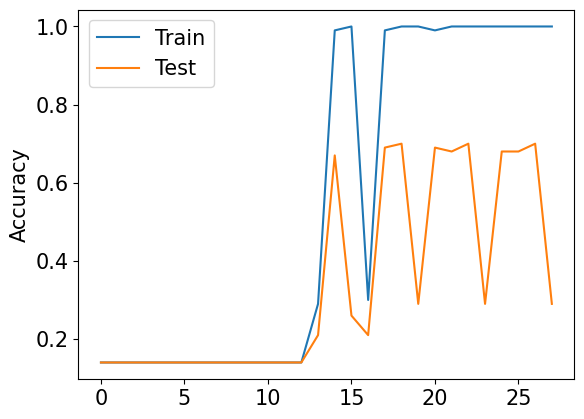

In [84]:
plt.rcParams["font.size"]=15
plt.plot(range(len(train_rate)), train_arr[:,2], label="Train")
plt.plot(range(len(test_rate)), test_arr[:,2], label="Test")
plt.ylabel("Accuracy")
plt.legend()

In [85]:
model = SVC(C=10, gamma=0.01)
model.fit(X_train[:100], y_train[:100])
print("학습용:",model.score(X_train, y_train))
print("검증용:",model.score(X_test, y_test))

학습용: 0.6991166666666667
검증용: 0.699


In [86]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.77      0.88      0.83       980
           1       0.47      1.00      0.64      1135
           2       0.88      0.25      0.39      1032
           3       0.56      0.76      0.65      1010
           4       0.51      0.53      0.52       982
           5       0.79      0.10      0.18       892
           6       0.76      0.81      0.79       958
           7       0.76      0.62      0.68      1028
           8       0.74      0.45      0.56       974
           9       0.45      0.55      0.50      1009

    accuracy                           0.61     10000
   macro avg       0.67      0.60      0.57     10000
weighted avg       0.67      0.61      0.58     10000



In [87]:
# 모형 저장
import pickle
pickle.dump(model, open('../models/mnist/mnist_svm.model', 'wb'))

In [88]:
# 모형 불러오기
model = pickle.load(open('../models/mnist/mnist_svm.model', 'rb'))
# 모형 사용
pred = model.predict(X_test[:10])
print('예측값:',pred[:10])
print('실제값:',y_test[:10])

예측값: [7 2 1 0 4 1 9 4 4 9]
실제값: [7 2 1 0 4 1 4 9 5 9]


In [89]:
# confusion matrix(혼동행렬, 오분류표) 출력

from sklearn.metrics import confusion_matrix
import pandas as pd

pred = model.predict(X_test)
cm = confusion_matrix(y_test, pred)
df_cm = pd.DataFrame(cm, index=range(10),
columns = range(10))
df_cm

,0,1,2,3,4,5,6,7,8,9
0,867,1,3,3,30,15,26,10,1,24
1,0,1108,1,1,2,1,0,0,17,5
2,15,196,615,5,127,4,5,25,30,10
3,13,30,43,847,9,4,3,8,31,22
4,1,6,1,0,843,0,14,6,0,111
5,48,22,7,312,103,250,24,21,31,74
6,15,32,12,1,232,18,639,0,0,9
7,1,52,20,19,22,2,0,812,17,83
8,54,50,83,87,70,10,10,10,476,124
9,13,10,8,29,331,2,2,78,3,533


9. mnist(인공신경망, sklearn)

In [90]:
from keras.datasets import mnist

# 학습용과 검증용 분리
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 데이터 전처리
X_train = X_train.reshape(60000, 784).astype('float32') / 255.0
X_test = X_test.reshape(10000, 784).astype('float32') / 255.0
print(y_train[:5])

[5 0 4 1 9]


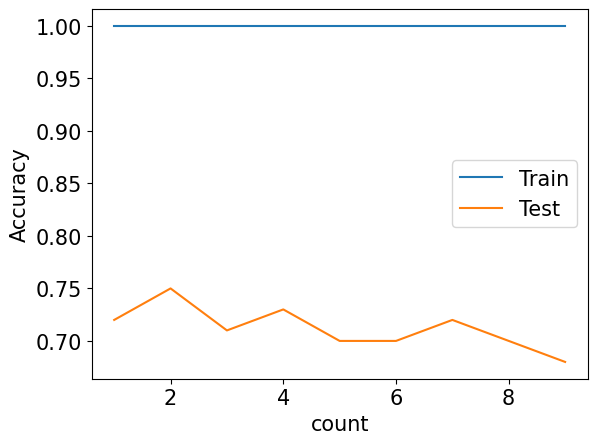

In [91]:
# 최적의 은닉노드 개수를 구하기 위한 실험
from sklearn.neural_network import MLPClassifier
import numpy as np
import matplotlib.pyplot as plt
train_rate=[]
test_rate=[]
for i in range(100,301,100): # 첫번째 은닉층의 노드수 100~300
    for j in range(100,301,100): # 두번째 은닉층의 노드수 100~300
        model=MLPClassifier(random_state=100,
        hidden_layer_sizes=[i,j],max_iter=1000)
        model.fit(X_train[:100],y_train[:100])
        train_rate.append(model.score(X_train[:100],y_train[:100]))
        test_rate.append(model.score(X_test[:100],y_test[:100]))
plt.rcParams['font.size']=15
plt.plot(range(1,10),train_rate,label='Train')
plt.plot(range(1,10),test_rate,label='Test')
plt.ylabel('Accuracy')
plt.xlabel('count')
plt.legend()

In [92]:
max_rate = max(test_rate) # 최대값
idx = np.where(test_rate == max_rate)[0][0] # 최대값의 인덱스값
print('idx:',idx)
print('최적의 정확도:',max_rate)
cnt=0
for i in range(100,301,100):
    for j in range(100,301,100):
        if cnt == idx:
            print(i,j)
            break
        cnt+=1

idx: 1
최적의 정확도: 0.75
100 200
200 100
300 100


In [93]:
# 실험을 통해 구한 최적의 은닉노드수로 만든 모형
model = MLPClassifier(hidden_layer_sizes=[100,200],random_state=100)
model.fit(X_train[:100],y_train[:100])
print("학습용:",model.score(X_train[:100], y_train[:100]))
print("검증용:",model.score(X_test[:100], y_test[:100]))

학습용: 1.0
검증용: 0.75


In [94]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86       980
           1       0.74      0.98      0.84      1135
           2       0.78      0.60      0.67      1032
           3       0.65      0.84      0.73      1010
           4       0.48      0.86      0.61       982
           5       0.82      0.28      0.42       892
           6       0.88      0.67      0.76       958
           7       0.84      0.79      0.81      1028
           8       0.79      0.49      0.60       974
           9       0.54      0.53      0.53      1009

    accuracy                           0.70     10000
   macro avg       0.73      0.69      0.68     10000
weighted avg       0.73      0.70      0.69     10000



In [95]:
# 모형 저장
import pickle
pickle.dump(model, open('../models/mnist/mnist_ann.model', 'wb'))

In [96]:
# 모형 불러오기
model = pickle.load(open('../models/mnist/mnist_ann.model', 'rb'))

# 모형 사용
pred = model.predict(X_test[:10])
print('예측값:',pred[:10])
print('실제값:',y_test[:10])

예측값: [7 2 1 0 4 1 9 4 4 9]
실제값: [7 2 1 0 4 1 4 9 5 9]


In [97]:
# confusion matrix(혼동행렬, 오분류표) 출력
from sklearn.metrics import confusion_matrix
import pandas as pd
pred = model.predict(X_test)
cm = confusion_matrix(y_test, pred)
df_cm = pd.DataFrame(cm, index=range(10), columns = range(10))
df_cm

,0,1,2,3,4,5,6,7,8,9
0,915,0,3,0,8,6,30,4,4,10
1,0,1080,1,1,1,1,1,0,49,1
2,29,174,662,10,73,5,23,13,30,13
3,12,29,55,800,8,16,10,5,37,38
4,3,12,2,0,849,1,31,7,0,77
5,58,12,22,248,128,247,32,15,86,44
6,37,28,15,0,140,7,726,1,1,3
7,2,47,19,9,33,4,1,752,17,144
8,57,79,48,41,98,22,11,11,423,184
9,14,12,6,10,412,3,3,121,1,427


10. mnist(인공신경망, keras)

In [98]:
from tensorflow.keras import datasets
from keras.utils import np_utils

# 데이터 준비
(X_train, y_train), (X_test, y_test) = datasets.mnist.load_data()
print(y_train[:5])

#one hot encoding
y_train = np_utils.to_categorical(y_train)
print(y_train[:5])
y_test = np_utils.to_categorical(y_test)
L, W, H = X_train.shape

# -1 샘플의 개수
X_train = X_train.reshape(-1, W * H)
X_test = X_test.reshape(-1, W * H)
X_train = X_train / 255.0
X_test = X_test / 255.0

[5 0 4 1 9]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [99]:
from keras.layers import Dense, Dropout
from keras.models import Sequential
# 분류 DNN 모델 구현 함수
def make_model(input_number, layers, output_number):
    #모델 초기화
    model = Sequential()
    model.add(Dense(layers[0], activation='relu', input_shape=(input_number,)))
    model.add(Dense(layers[1], activation='relu'))
    model.add(Dense(layers[2], activation='relu'))
    # 드롭아웃 계층 Dropout(p) p라는 확률로
    # 출력 노드의 신호를 보내다 말다 함, 과적합 방지
    model.add(Dropout(0.2))
    # 출력층
    model.add(Dense(output_number, activation='softmax', name='output'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [100]:
input_number = 784 # 28x28

# 은닉계층 3개, 은닉노드수 128개, 64개, 32개
hidden_layers = [128, 64, 32]
print(hidden_layers)
number_of_class = 10
output_number = number_of_class

# 모델 생성
model = make_model(input_number, hidden_layers, output_number)

[128, 64, 32]


In [101]:
# 모델 학습
hist = model.fit(X_train, y_train, epochs=5, batch_size=128, validation_split=0.2)

Epoch 1/5
375/375 [==============================] - 3s 4ms/step - loss: 0.5134 - accuracy: 0.8465 - val_loss: 0.1838 - val_accuracy: 0.9455
Epoch 2/5
375/375 [==============================] - 1s 4ms/step - loss: 0.2075 - accuracy: 0.9413 - val_loss: 0.1454 - val_accuracy: 0.9587
Epoch 3/5
375/375 [==============================] - 1s 3ms/step - loss: 0.1470 - accuracy: 0.9579 - val_loss: 0.1078 - val_accuracy: 0.9686
Epoch 4/5
375/375 [==============================] - 1s 4ms/step - loss: 0.1186 - accuracy: 0.9669 - val_loss: 0.1137 - val_accuracy: 0.9668
Epoch 5/5
375/375 [==============================] - 2s 4ms/step - loss: 0.0943 - accuracy: 0.9734 - val_loss: 0.1025 - val_accuracy: 0.9706


In [102]:
# 모델 평가
model.evaluate(X_test, y_test, batch_size=128)

79/79 [==============================] - 0s 3ms/step - loss: 0.0983 - accuracy: 0.9688


[0.09833438694477081, 0.9688000082969666]

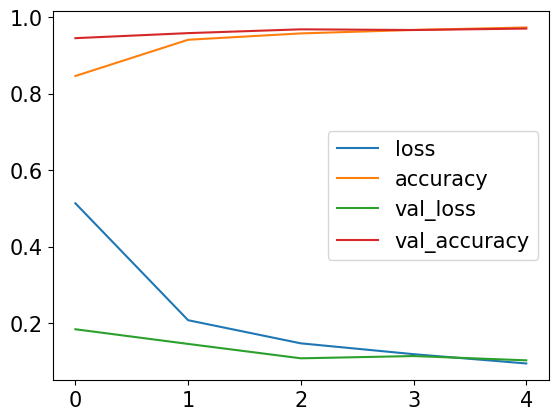

In [103]:
# 모델 학습 과정 표시
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'])
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_loss'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['loss','accuracy','val_loss','val_accuracy'])
plt.show()